In [29]:
from __future__ import division, print_function, absolute_import

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import scipy
from scipy import misc

import skimage
import PIL
from skimage import transform, io
from functools import reduce
from itertools import product

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import fnmatch
import time
import warnings
from joblib import Parallel, delayed

import tensorflow as tf
import keras
from keras.utils import Sequence
from keras import models, layers
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model, Model
from keras.layers import  LeakyReLU, concatenate, Input, Flatten, Dense, Activation, PReLU,\
                          Conv2D, UpSampling2D, add, Lambda, BatchNormalization, Conv2DTranspose
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.optimizers import Adam
import keras.losses

from tqdm import tqdm_notebook as tqdm

warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
# set data directories
train_dir = '../dataset/probav_data/train/'
test_dir = '../dataset/probav_data/test/'
norm_dir = "../dataset/probav_data/norm.csv"
red_train = os.path.join(train_dir, 'RED')
nir_train = os.path.join(train_dir, 'NIR')
red_test = os.path.join(test_dir, 'RED')
nir_test = os.path.join(test_dir, 'NIR')
print("train set: {} RED {} NIR = {} Total".format(len(os.listdir(red_train)),
                                                   len(os.listdir(nir_train)),
                                                   len(os.listdir(red_train))+ len(os.listdir(nir_train))))
print("test set: {} RED {} NIR = {} Total".format(len(os.listdir(red_test)),
                                                   len(os.listdir(nir_test)),
                                                   len(os.listdir(red_test))+ len(os.listdir(nir_test))))
os.listdir(red_train)[:10]

train set: 594 RED 566 NIR = 1160 Total
test set: 146 RED 144 NIR = 290 Total


['imgset0323',
 'imgset0338',
 'imgset0257',
 'imgset0373',
 'imgset0286',
 'imgset0339',
 'imgset0164',
 'imgset0026',
 'imgset0335',
 'imgset0054']

In [4]:
sorted(os.listdir(os.path.join(red_train, 'imgset0323')))

['HR.png',
 'LR000.png',
 'LR001.png',
 'LR002.png',
 'LR003.png',
 'LR004.png',
 'LR005.png',
 'LR006.png',
 'LR007.png',
 'LR008.png',
 'LR009.png',
 'LR010.png',
 'LR011.png',
 'LR012.png',
 'LR013.png',
 'LR014.png',
 'LR015.png',
 'LR016.png',
 'LR017.png',
 'LR018.png',
 'LR019.png',
 'QM000.png',
 'QM001.png',
 'QM002.png',
 'QM003.png',
 'QM004.png',
 'QM005.png',
 'QM006.png',
 'QM007.png',
 'QM008.png',
 'QM009.png',
 'QM010.png',
 'QM011.png',
 'QM012.png',
 'QM013.png',
 'QM014.png',
 'QM015.png',
 'QM016.png',
 'QM017.png',
 'QM018.png',
 'QM019.png',
 'SM.png']

we have two folders, training data and testing data, each one has two folders, one contains the NIR images and the other contains the RED images.<br>
In the training set, for each scene we have one high resolution image (which we need to construct) and several low resolution images. for each image we have a status map that indicates the clear pixels<br>


so let's take a look at the data

In [5]:
image = io.imread(os.path.join(red_train, 'imgset0323', 'HR.png'))
print(image.dtype, image.shape)

uint16 (384, 384)


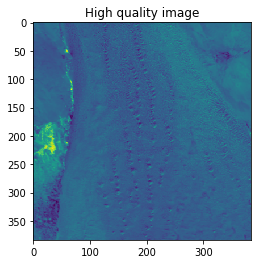

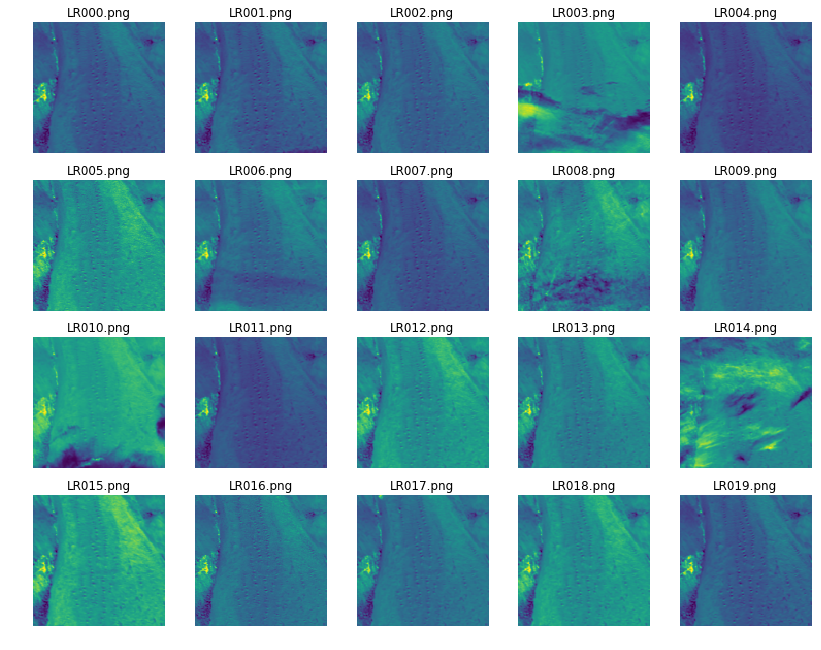

In [6]:
example = 'imgset0323'
hr = io.imread(os.path.join(red_train, example, 'HR.png'))
plt.imshow(hr)
plt.title("High quality image")
fig = plt.figure(figsize=(14, 14))
num_image = len(glob(os.path.join(red_train, example) + '/LR*.png'))
for i, im in enumerate(sorted(glob(os.path.join(red_train, example) + '/LR*.png'))):
    image = io.imread(im)
    ax = fig.add_subplot(num_image/5+1, 5, i+1)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(im.split('/')[-1])

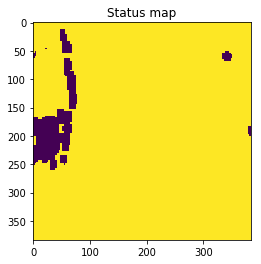

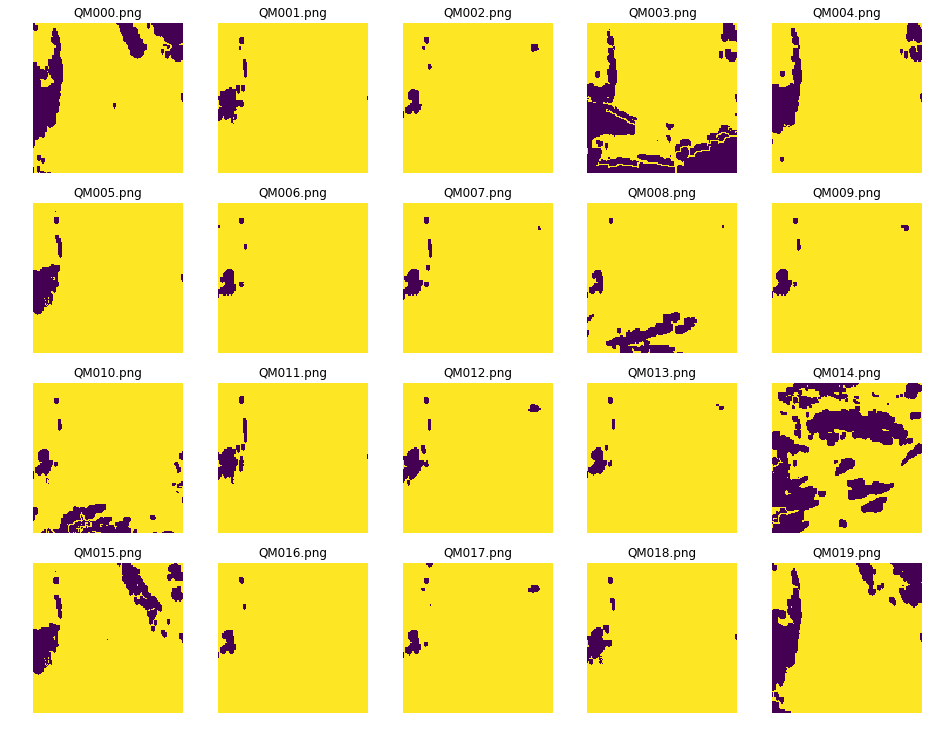

In [7]:
sm = io.imread(os.path.join(red_train, example, 'SM.png'))
plt.imshow(sm)
plt.title("Status map")
fig = plt.figure(figsize=(16, 16))
num_image = len(glob(os.path.join(red_train, example) + '/QM*.png'))
for i, im in enumerate(sorted(glob(os.path.join(red_train, example) + '/QM*.png'))):
    image = io.imread(im)
    ax = fig.add_subplot(num_image/5+1, 5, i+1)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(im.split('/')[-1])
    

In [8]:
# norm contains the PSNR of each image for the baseline upscaling
norm = pd.read_csv(norm_dir, names=['file name', 'PSNR'], sep= ' ')
norm.head()

file name       PSNR
0  imgset0000  52.352173
1  imgset0001  46.464812
2  imgset0002  48.646021
3  imgset0003  45.709971
4  imgset0004  52.947346

In [9]:
norm.shape

(1450, 2)

Let's write some helper function to display and compare images

In [10]:
def get_folder(path):
    """list all image path in a folder (train or test)"""
    listing = [os.path.join(path, i, j) for i in ['RED', 'NIR'] for j in os.listdir(os.path.join(path, i))]
    return sorted(listing, key=lambda x: x[-4:])

In [11]:
def read_img(path, extend = True):
    """read an image from path
    if extend = True add a 3rd axis for channel"""
    img = skimage.img_as_float64(io.imread(path).astype(np.uint16))
    if extend:
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [12]:
def read_imgs(paths, img_size, extend = True):
    images = np.zeros((len(paths), img_size, img_size, 1))
    for i, path in enumerate(paths):
        images[i, ...] = read_img(path, extend)
    return images

In [13]:
def get_hr(folder_path, extend=False):
    """get the high resolution image with its correspending status map
    """
    # to have value between 0 and 1
    try:
        hr = skimage.img_as_float64(io.imread(folder_path + '/HR.png').astype(np.uint16))
        sm = io.imread(folder_path + '/SM.png').astype(np.bool)
    except FileNotFoundError:
        hr = None
        sm = None
    if extend:
        hr = np.expand_dims(hr, -1)
        sm = np.expand_dims(sm, -1)
    return hr, sm

In [14]:
def get_lr(folder_path, extend=False):
    """generator of low resolution image and its corresponding status map 
    Parameters:
        path : path to the folder containing the images
    Returns:
        generator of a tuple of lr image and status map"""
    for file in glob(folder_path+'/LR*.png'):
        lr = read_img(file, extend = extend)
        QM = file.replace('LR', 'QM')
        qm = io.imread(QM).astype('bool')
        if extend:
            qm = np.expand_dims(qm, -1)
        yield (lr, qm)

In [15]:
train_folds = get_folder(train_dir)
test_folds = get_folder(test_dir)
train_folds[:6]

['../dataset/probav_data/train/RED/imgset0000',
 '../dataset/probav_data/train/RED/imgset0001',
 '../dataset/probav_data/train/RED/imgset0002',
 '../dataset/probav_data/train/RED/imgset0003',
 '../dataset/probav_data/train/RED/imgset0004',
 '../dataset/probav_data/train/RED/imgset0005']

In [16]:
hr, sm = get_hr(train_folds[3])

In [17]:
np.min(hr), np.mean(hr), np.max(hr)

(0.013183794918745708, 0.07108435053523138, 0.16870374608987565)

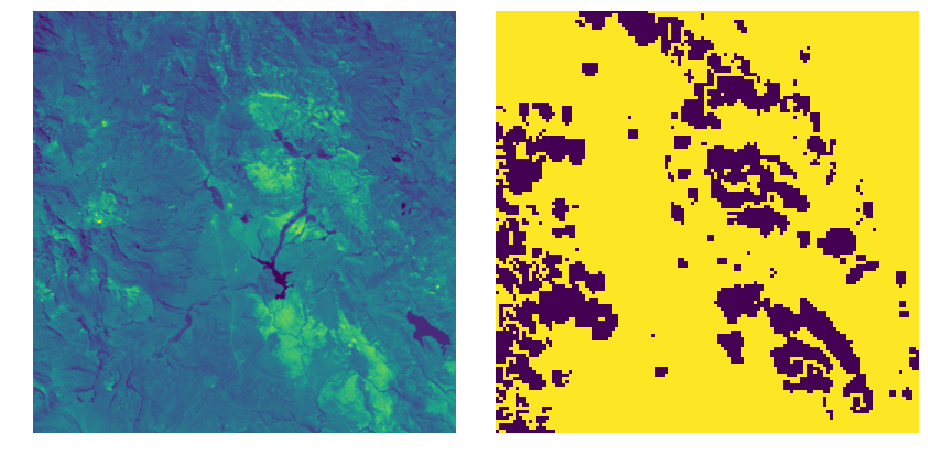

In [30]:
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(121).imshow(hr); plt.axis('off')
ax2 = fig.add_subplot(122).imshow(sm); plt.axis('off')
fig.tight_layout()
fig.show()

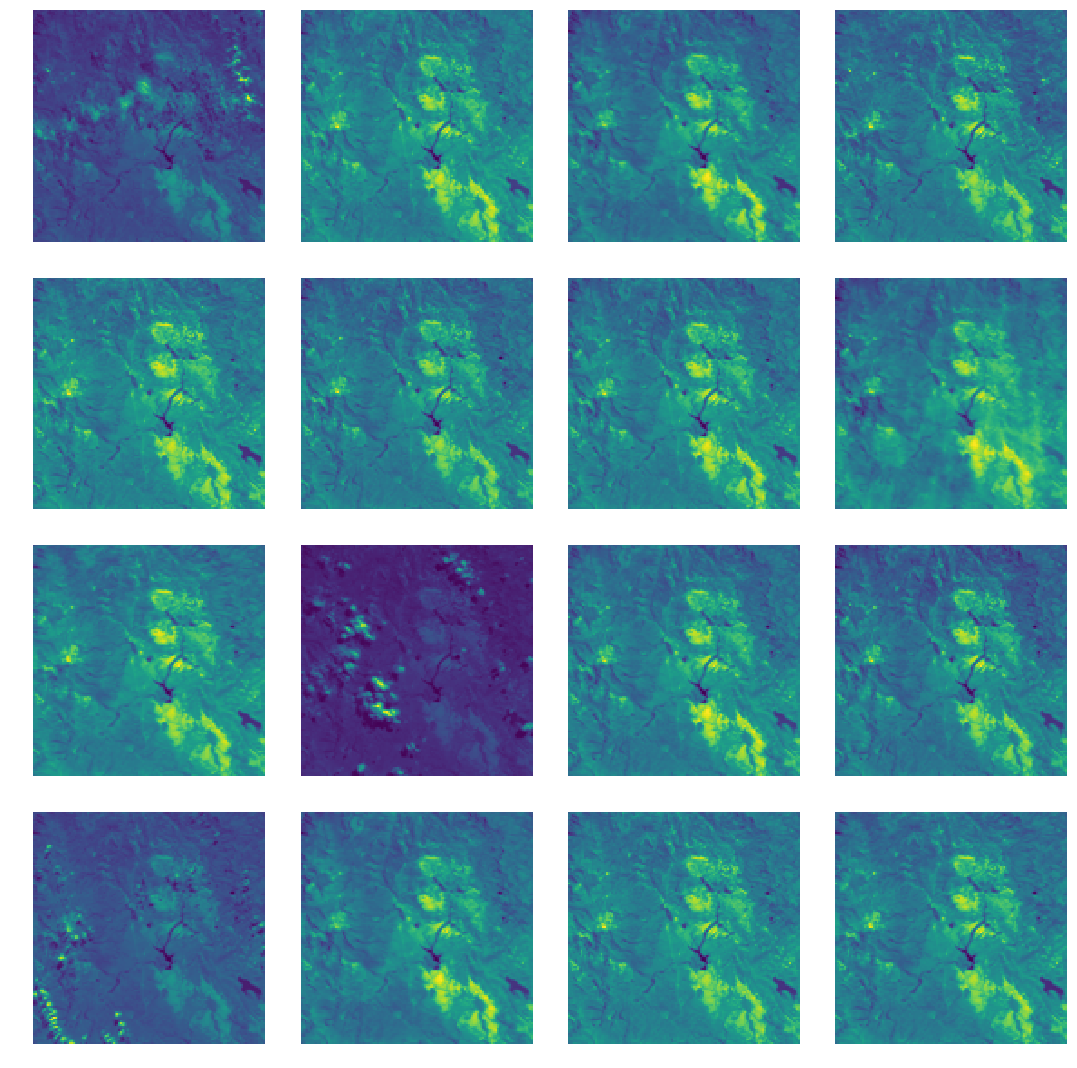

In [31]:
fig = plt.figure(figsize=(15, 15))
for i, (lr, sm) in enumerate(get_lr(train_folds[3])):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(lr)
    plt.axis('off')
    if i == 15:
        break
fig.tight_layout()
fig.show()

The first approach that we will use (and also the simplest one), is to try to construct the HR image by aggregating the LR images<br>
we have many option, for this aggregation, first let's write a function to to aggregate the pixels wither to consider only the clear pixel or aggregate all pixels

In [20]:
# we will use the bicubic transformation to upscaling images 
def bicubic_transform(lr, scale=3, order=3,mode = 'edge'):
    """funtion to perform the bicubic transformation
    using skimage library"""
    lr = transform.rescale(lr, scale=scale, order=order, mode=mode, anti_aliasing=False)
    return lr

In [21]:
def baseline_upscale(path, upscale = True):
    
    """this is the function provided by the competition to 
    performe baseline upscalling by averaging picture with maximum clearance"""
    clearance = []
    for file in glob(path + '/QM*.png'):
        qm = io.imread(file).astype('bool')
        clearance.append((np.sum(qm), file[-7:-4]))
    maxcl = max([x[0] for x in clearance])
    maxclears = [x[1] for x in clearance if x[0] == maxcl]

    # upscale and aggregate images with maximum clearance together
    img = np.zeros( (384, 384), dtype=np.float)
    for idx in maxclears:
        lrfn = '/LR{}.png'.format(idx)
        lr = read_img(path + lrfn, extend=False)
        # bicubic upscaling
        if upscale:
            img += transform.rescale(lr, scale=3, order=3, mode='edge', anti_aliasing=False, multichannel=False)
        else:
            img += lr
    img /= len(maxclears)
    return img    

In [22]:
def agg_image(path, agg_fc= 'median', use_sm = True, extend = False):
    
    """combine the LR images by aggregate their pixels
    
    Parameters:
        path:path to the folder of the image
        agg_fc: function to use to aggregate pixels
                it can be one of "mean", "median" and "mode"
                example are np.nanmean, np.nanmax, np.nanmedian, scipy.stats.mode
        use_sm : a boolean parameter to choose whether to use status map or
                to include all pixels
        extend : a boolean parameter to add a 3rd axis or not
    Returns:
        image with 384x384 resolution
    """
    
    agg_opts = {
        'mean'   : lambda i: np.nanmean(i, axis=0),
        'median' : lambda i: np.nanmedian(i, axis=0),
        'mode'   : lambda i: scipy.stats.mode(i, axis=0, nan_policy='omit').mode[0],
        }
    agg = agg_opts[agg_fc]

    lr_sm_list = list(get_lr(path))
    lr_list = []
    lr_nan = []
    for (lr, sm) in lr_sm_list:
        if use_sm:
            temp = lr.copy()
            temp[sm] = np.nan
            lr_nan.append(temp)
            lr[~sm] = np.nan
        lr_list.append(lr)
    agg_img = agg(lr_list)
    if use_sm :
        some_clear = np.isnan(lr_nan).any(axis=0)
        lr_nan= agg(lr_nan)
        lr_nan[some_clear] = 0.0
        np.nan_to_num(agg_img, copy=False)
        agg_img += lr_nan
    if extend:
        agg_img = np.reshape(agg_img, (agg_img.shape[0], agg_img.shape[1], 1))
    return agg_img

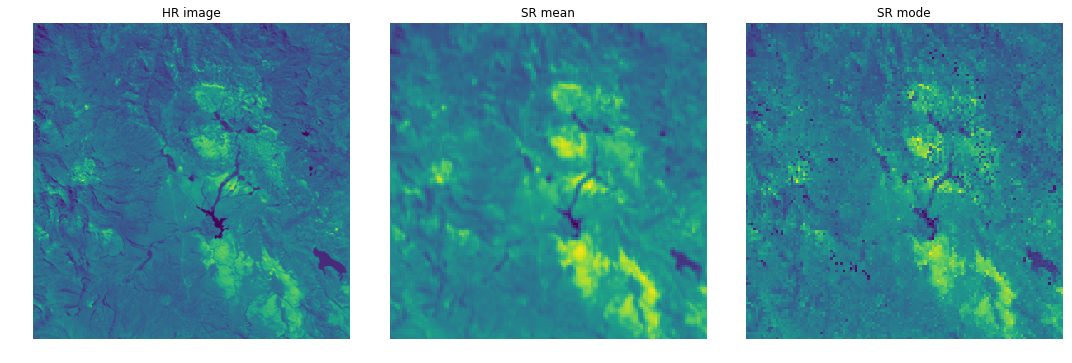

In [32]:
example = train_folds[3]
hr_image,_ = get_hr(example)
sr_image = agg_image(example, "mean", use_sm=False)
sr_image2 = agg_image(example, "mode", use_sm=False)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(131); ax.imshow(hr_image); ax.set_title('HR image');plt.axis('off')
ax = fig.add_subplot(132); ax.imshow(sr_image); ax.set_title('SR mean');plt.axis('off')
ax = fig.add_subplot(133); ax.imshow(sr_image2); ax.set_title('SR mode');plt.axis('off')
fig.tight_layout()
fig.show()

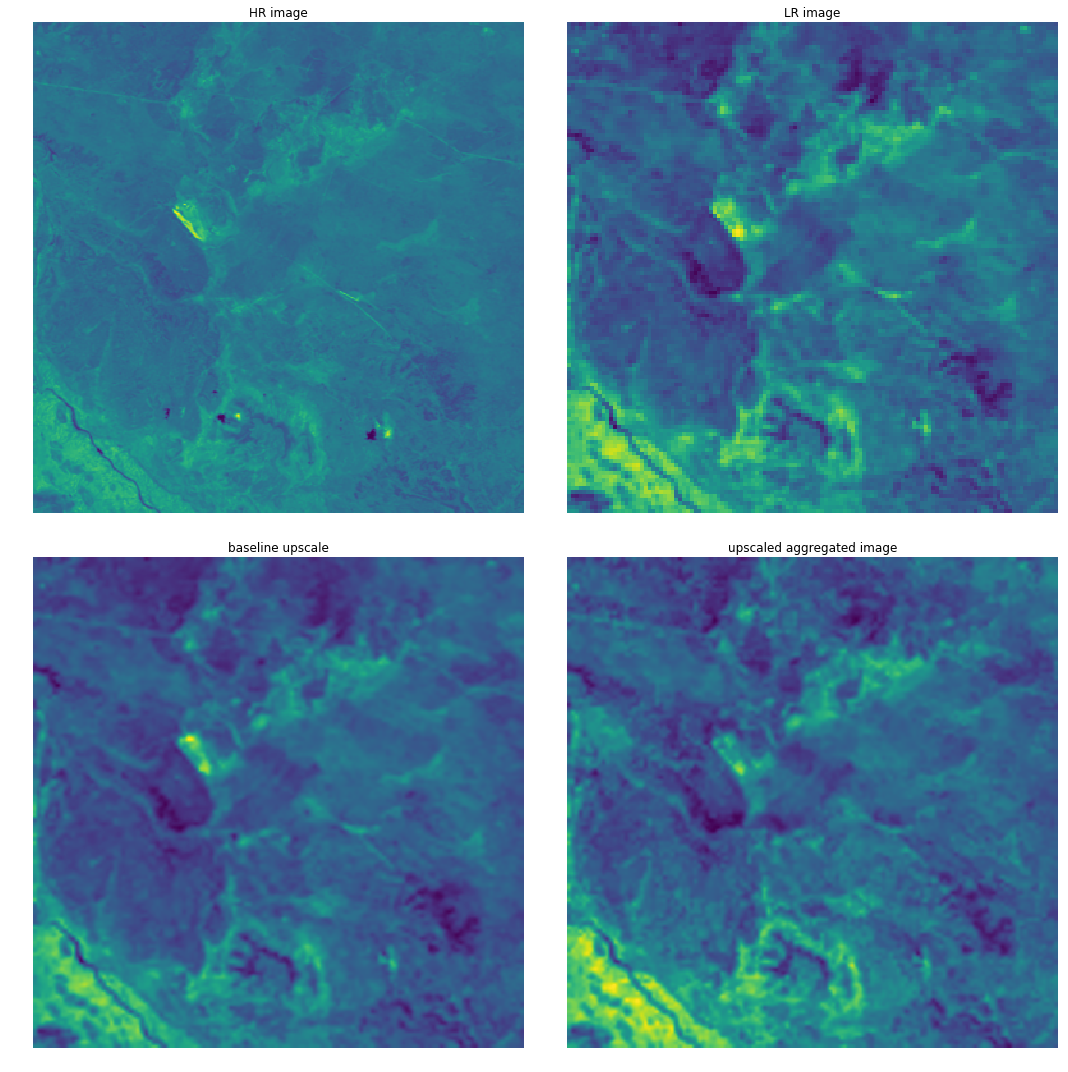

In [33]:
example = train_folds[5]
hr_image,_ = get_hr(example)
lr_image, _ = list(get_lr(example))[1]
upscale_lr_image = baseline_upscale(example)
sr_image = bicubic_transform(agg_image(example, "median", use_sm=True))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221); ax.imshow(hr_image); ax.set_title('HR image');plt.axis('off')
ax = fig.add_subplot(222); ax.imshow(lr_image); ax.set_title('LR image');plt.axis('off')
ax = fig.add_subplot(223); ax.imshow(upscale_lr_image); ax.set_title('baseline upscale');plt.axis('off')
ax = fig.add_subplot(224); ax.imshow(sr_image); ax.set_title('upscaled aggregated image');plt.axis('off')
fig.tight_layout()
fig.show()

In [34]:
# in order to compare results, we will write a function 
# to calculate the cPSNR which is the used in th competition 

def cPSNR_image(hr_path, sr, norm_path=norm_dir):
    
    """function to calculate the clear peak signal to noise rate
    it is the metric used in the proba_v competition. This metric uses
    the norm.csv file that contains the baseline cPSNR"""
    
    # see https://kelvins.esa.int/proba-v-super-resolution/scoring/
    if isinstance(sr, str):
        sr = skimage.img_as_float64(io.imread(sr).astype(np.uint16))
    # read the file containing the baseline cPSNR
    norm = pd.read_csv(norm_path, sep=' ', names=['image', 'cPSNR'], index_col='image')
    # transform it to pandas Series
    norm = norm.T.squeeze()
    # we crop the HR image so we should also crop th SR image
    sr_crop = sr[3:-3, 3:-3]
    # list individual score of SR for each u, v in {0, 1, ... , 6}
    z = []
    if hr_path.endswith('.png'):
        hr_path = os.path.dirname(hr_path)
    image_id = hr_path[-10:]
    hr, sm = get_hr(hr_path)
    for u, v in product(range(7), range(7)):
        # crop the image so that its upper left corner at coordinates (u,v)
        # and its lower right corner at (378+u,378+v)
        hr_uv = hr[u:378+u, v:378+v]
        sm_uv = sm[u:378+u, v:378+v]
        b = np.mean(hr_uv[sm_uv] - sr_crop[sm_uv])
        cMSE = np.mean((hr_uv[sm_uv] - sr_crop[sm_uv]-b)**2)
        cPSNR = -10.*np.log10(cMSE)
        z.append(norm[image_id]/cPSNR)
    return np.min(z)        

In [35]:
def cPSNR_images(hr_images, sr_images, norm_path = norm_dir):
    
    """function to calculate the total score of a submission
    Parameters:
        hr_images: list of paths to the HR images, it can be the train folder 
                    path or the test folder
        sr_images: list of sr images or sr path
        norm_path : path to the norm.csv file
    Returns:
        the mean score of all images in images_path
        """
    return  np.mean([cPSNR_image(path_i, sr_i) for path_i, sr_i in zip(hr_images, sr_images)])

In [36]:
for i in range(5):
    example = train_folds[i]
    sr_mean = bicubic_transform(agg_image(example, "mean", use_sm=True))
    sr_median = bicubic_transform(agg_image(example, "median", use_sm=True))
    sr_base = baseline_upscale(example)
    print("image {}: PSNR for mean is {}".format(i, cPSNR_image(example, sr_mean)))
    print("image {}: PSNR for median is {}".format(i, cPSNR_image(example, sr_median)))
    print("image {}: PSNR for baseline is {}".format(i, cPSNR_image(example, sr_base)))

image 0: PSNR for mean is 1.001249990763183
image 0: PSNR for median is 1.0009942718556841
image 0: PSNR for baseline is 1.0000000000000002
image 1: PSNR for mean is 1.0012523915564606
image 1: PSNR for median is 0.9945261552038163
image 1: PSNR for baseline is 0.9999999999999999
image 2: PSNR for mean is 1.0167645734256874
image 2: PSNR for median is 1.0250578577660594
image 2: PSNR for baseline is 0.9999999999999999
image 3: PSNR for mean is 1.0282853065429687
image 3: PSNR for median is 1.0246766050890614
image 3: PSNR for baseline is 0.9999999999999991
image 4: PSNR for mean is 0.9925947874170301
image 4: PSNR for median is 0.986741861689131
image 4: PSNR for baseline is 0.9999999999999991


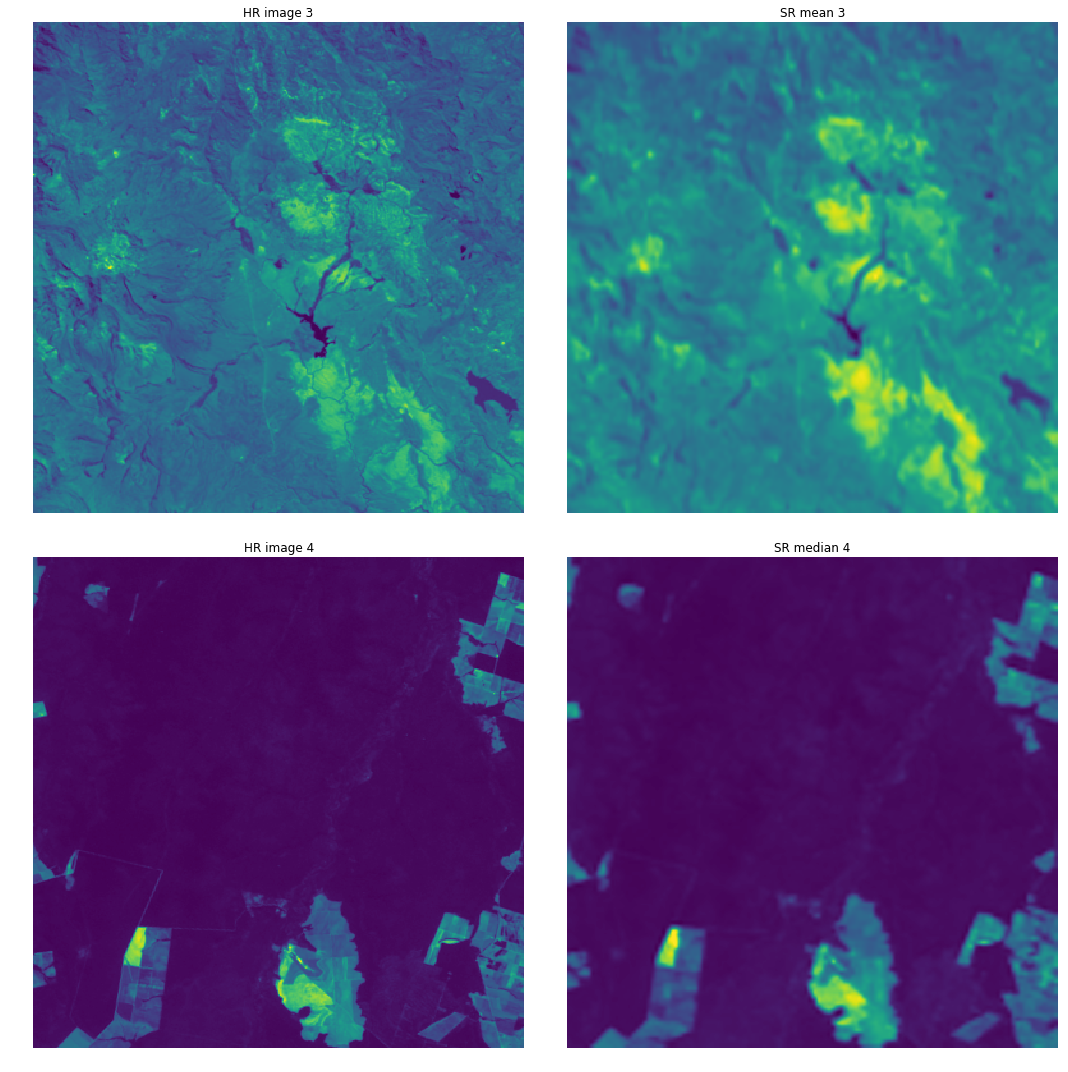

In [37]:
# a bad example compared to baseline
example1 = train_folds[3]
hr_image1,_ = get_hr(example1)
sr_image1 = bicubic_transform(agg_image(example1, "mean", use_sm=False))

# a good example compared to baseline
example2 = train_folds[4]
hr_image2,_ = get_hr(example2)
sr_image2 = bicubic_transform(agg_image(example2, "median", use_sm=True))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221); ax.imshow(hr_image1); ax.set_title('HR image 3');plt.axis('off')
ax = fig.add_subplot(222); ax.imshow(sr_image1); ax.set_title('SR mean 3');plt.axis('off')
ax = fig.add_subplot(223); ax.imshow(hr_image2); ax.set_title('HR image 4');plt.axis('off')
ax = fig.add_subplot(224); ax.imshow(sr_image2); ax.set_title('SR median 4');plt.axis('off')
fig.tight_layout()
fig.show()

In [38]:
%%time
# let's apply aggregation with median and upscale with bicubic transformnation
# and calculate the total score on the training set
sr_median_all = [bicubic_transform(agg_image(path_i, agg_fc="median")) for path_i in train_folds]
total_score = np.mean([cPSNR_image(path_i, sr_i) for path_i, sr_i in zip(train_folds, sr_median_all)])
print(total_score)

1.003692235921427
CPU times: user 3min 19s, sys: 1min 56s, total: 5min 15s
Wall time: 2min 37s


In [39]:
del sr_median_all

The upscaled image using median is slightly worst than the baseline upscaling used in the competition<br>
the amount of noise due to upscaling differ from a picture to another,
in general picture with more details are difficult to construct.

Using basic method did not give good result<br>
we will apply machine learning models to tackle this problem<br>


## CNN

first we will try to reconstruct the HR image by using and CNN model that takes as input LR
and outputs the SR image<br>
the labels are the HR images and the loss function is the pixel wise MSE between the SR image and HR image
we will use keras library to construct the neural network<br>
we will implement the FSRCNN which is the Fast super resolution CNN. it is composed of 5 blocks<br>
   - a feature extraction block that extract feature from the low resolution image, it is composed of a Convolutional layer with `d` filters and kernel of size `5x5` 
   - a shrinkage block that is used to reduce the computation complexity of the model, it is composed of one convolution layer with `1x1` kernel and `s` filters such as `s` is smaller than `d`
   - a mapping block that learn the pattern between the LR image and HR image. it is composed of `m` convolution layers with kernel of size `3x3` and `s` filters.
   - an expanding block which invert the process of the shrinkage layer and expand the HR image dimention. It is made of a convolution layer with `d` filters and `1x1` kernel.
   - a deconvolution block that is used to aggregate the previous features and also to upscale the image. it is composed of a deconvolution layer with `1` filter and kernel of size `9x9`

### SRCNN : input baseline upscaled image

At first we will combine all images using the baseline upscaling function

In [40]:
LR_IMG_SIZE = 128
HR_IMG_SIZE = 384

In [52]:
np.mean(norm)

PSNR    46.378919
dtype: float64

In [76]:
def PSNR(y_true, y_pred):
    """function to calculate the peak signal to noise rate
    we will used as the loss """
    b = K.mean(y_true - y_pred, axis=(1, 2, 3))
    cMSE = K.mean((y_true - y_pred - b)**2, axis=(1, 2, 3))
    cPSNR = -10.*(K.log(cMSE)/K.log(10.))
    return K.mean(46.37/cPSNR)
    #return cMSE

In [77]:
# so that keras know the loss function when loading the model
keras.losses.PSNR = PSNR

In [63]:
def srcnn(lr_dim = 384, channels=1):
    
    inputs = Input((lr_dim, lr_dim, channels))
    
    x = Conv2D(filters=32, kernel_size=9, activation="relu", padding="same")(inputs)
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=3, activation='relu',padding='same')(x)
    x = Conv2D(filters=64, kernel_size=3, activation='relu',padding='same')(x)
    x = Conv2D(filters=32, kernel_size=5, activation="relu", padding="same")(x)
    
    out = Conv2D(filters=1, kernel_size=5, padding="same", activation="sigmoid")(x)
    
    return Model(inputs, out)

In [64]:
model = srcnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 384, 384, 1)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 384, 384, 32)      2624      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 384, 384, 32)      9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 384, 384, 64)      18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 384, 384, 128)     73856     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 384, 384, 64)      73792     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 384, 384, 32)      51232     
__________

In [65]:
# we will slightly change the generator
class DataGeneratorV2(Sequence):
    def __init__(self, list_paths, batch_size = 64, 
                 hr_dim=(384,384), n_channels=1, shuffle=True):
        'Initialization different parameters'
        self.hr_dim = hr_dim
        self.batch_size = batch_size
        self.list_paths = list_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'suffle indexes after each epoch'
        self.indexes = np.arange(len(self.list_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def _data_generation(self, list_IDs_temp):
        
        # Initialization
        X = np.empty((self.batch_size, *self.hr_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.hr_dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = baseline_upscale(ID)[..., np.newaxis]
            y[i,], _ = get_hr(ID, extend=True)

        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_paths) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.list_paths[k] for k in indexes]
        # Generate data
        X, y = self._data_generation(list_IDs_temp)

        return X, y

In [66]:
fsrcnnV2_params = {'hr_dim': (384,384),
          'batch_size': 32,
          'n_channels': 1,
          'shuffle': True}

fsrcnnV2_checkpoint_path = './saved_models/fsrcnnV2.ckpt'
fsrcnnV2_model_path = './saved_models/fsrcnnV2.h5'
fsrcnnV2_model_params = dict(lr_dim = 384, channels=1)
fsrcnnV2_predict_dir = './predictions/fsrcnnV2/train/'

In [67]:
for folder in [fsrcnnV2_checkpoint_path, fsrcnnV2_model_path, fsrcnnV2_predict_dir]:
    folder = os.path.dirname(folder)
    os.makedirs(folder, exist_ok=True)

In [68]:
train_data = DataGeneratorV2(list_paths = X_train, **fsrcnnV2_params)
val_data = DataGeneratorV2(list_paths = X_val, **fsrcnnV2_params)

In [69]:
train(train_data, val_data, srcnn, fsrcnnV2_checkpoint_path, fsrcnnV2_model_path, epochs=300, loss= PSNR, **fsrcnnV2_model_params)

Epoch 1/300
 3/29 [==>...........................] - ETA: 17:27 - loss: 1.5547 - mean_squared_error: 0.1733

KeyboardInterrupt: 

In [63]:
params = {'list_paths': train_folds,
          'batch_size': len(train_folds),
          'shuffle': False}
all_data = DataGeneratorV2(**params)

In [ ]:
predict(all_data, srcnn, fsrcnnV2_checkpoint_path, fsrcnnV2_model_path, **fsrcnnV2_model_params)

In [ ]:
model = models.load_model(fsrcnnV2_model_path)
model.summary()

In [ ]:
for i in range(5):
    example = train_folds[i]
    lr_image = baseline_upscale(example)
    lr_image = lr_image[np.newaxis, ...]
    lr_image = lr_image[..., np.newaxis]
    sr_image = model.predict(lr_image)
    hr_image, _ = get_hr(example)
    fig = plt.figure(figsize=(20, 20))
    
    ax = fig.add_subplot(5, 3, i*3+1);
    ax.imshow(hr_image); 
    ax.set_title('HR image');
    plt.axis('off')
    
    ax = fig.add_subplot(5, 3, i*3+2); ax.imshow(sr_image[0, :,:,0]);
    ax.set_title('SR image {:.6f}'.format(np.mean(np.square(hr_image - sr_image))));
    plt.axis('off')
    
    ax = fig.add_subplot(5, 3, i*3+3); 
    ax.imshow(lr_image[0, :,:,0]); 
    ax.set_title('LR image');plt.axis('off')
    plt.tight_layout()

In [ ]:
sr_paths = [fsrcnnV2_predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

### FSRCNN aggregate all LR image 

In [41]:
def fsrcnn(d, s, m, channels=1, lr_dim = 128, scale = 3):
    model = keras.Sequential([
        
        # feature extraction block
        layers.Conv2D(filters=d, kernel_size=5, strides=(1,1), padding='same', 
                      input_shape=(lr_dim, lr_dim, channels)),
        layers.PReLU(),
        # shrinkage block
        layers.Conv2D(filters=s, kernel_size=1, strides=(1,1), padding='same'),
        layers.PReLU()] + 

        #mapping block
        [layers.Conv2D(filters=s, kernel_size=3, strides=(1,1), padding='same', activation='elu') for _ in range(m)] + 

        [
            # expanding block
            layers.Conv2D(filters=d, kernel_size=1, strides=(1,1), padding='same'),
            layers.PReLU(),
            # deconvolution block
            layers.Conv2DTranspose(filters=1, kernel_size=9, strides=(scale,scale), 
                                             padding='same')
    ])
    return model

In [42]:
X_train, X_val = train_test_split(train_folds, test_size=0.2, random_state = 123)

In [43]:
len(X_train)

928

In [44]:
# we will write a data generator class that inherites from Keras Sequence class
# we will use it to generate batchs of images and to apply any kind
# of transformations on the images
class DataGenerator(Sequence):
    def __init__(self, list_paths, batch_size = 64,
                 lr_dim=(128,128), hr_dim=(384,384), n_channels=1, shuffle=True):
        'Initialization different parameters'
        self.lr_dim = lr_dim
        self.hr_dim = hr_dim
        self.batch_size = batch_size
        self.list_paths = list_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'suffle indexes after each epoch'
        self.indexes = np.arange(len(self.list_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def _data_generation(self, list_IDs_temp):
        
        # Initialization
        X = np.empty((self.batch_size, *self.lr_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.hr_dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = agg_image(ID, "median", use_sm=True, extend=True)
            y[i,], _ = get_hr(ID, extend=True)

        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_paths) / self.batch_size))
    
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        list_IDs_temp = [self.list_paths[k] for k in indexes]
        # Generate data
        X, y = self._data_generation(list_IDs_temp)

        return X, y

In [45]:
def train(train_data, val_data, arch,checkpoint_path, model_path,epochs= 100, loss = 'mse', **kwargs):
    model = arch(**kwargs)
    model.compile(optimizer= 'adam', loss=loss, metrics=['mse'])
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, mode='min')
    model.fit_generator(train_data, epochs=epochs, validation_data = val_data,
                                  callbacks=[checkpoint])
    model.save(model_path)

In [46]:
def predict(generator, arch, checkpoint_path, model_path=None, paths = train_folds,
            out = './predictions/train/', loss = 'mse', **kwargs):
    
    if model_path is None:
        model = arch(**kwargs)
        model.load_weights(checkpoint_path)
        model.compile(optimizer= 'adam', loss=loss, metrics=['mse'])
    else:
        model = load_model(model_path)
    
    sr_path = [out + '/'.join(path.split('/')[-2:]) for path in paths]
    for path in sr_path:
        os.makedirs(path, exist_ok=True)
    X, _ = generator._data_generation(paths)
    # make prediction
    sr = model.predict(X)
    def save_prediction():
        Parallel(n_jobs=10)(delayed(io.imsave)(path + '/SR.png', img) for path, img in zip(sr_path, sr))
    
    # Save prediction
    save_prediction()

In [47]:
params = {'lr_dim': (128,128),
          'hr_dim': (384,384),
          'batch_size': 16,
          'n_channels': 1,
          'shuffle': True}

checkpoint_path = './saved_models/fsrcnn.ckpt'
model_path = './saved_models/fsrcnn.h5'
model_params = dict(d=56, s=12, m=4, channels=1, lr_dim = 128, scale = 3)
predict_dir = './predictions/fsrcnn/train/'

In [48]:
for folder in [checkpoint_path, model_path, predict_dir]:
    folder = os.path.dirname(folder)
    os.makedirs(folder, exist_ok=True)

In [49]:
train_data = DataGenerator(list_paths = X_train, **params)
val_data = DataGenerator(list_paths = X_val, **params)

In [726]:
# since I don't have a gpu, I ran it for only 300 epochs
train(train_data, val_data, fsrcnn,checkpoint_path, model_path,epochs=300, **model_params)

Epoch 1/300
58/58 [==============================] - 86s 1s/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 2.1808e-04 - val_mean_squared_error: 2.1808e-04
Epoch 2/300
58/58 [==============================] - 66s 1s/step - loss: 1.4791e-04 - mean_squared_error: 1.4791e-04 - val_loss: 1.3191e-04 - val_mean_squared_error: 1.3191e-04
Epoch 3/300
58/58 [==============================] - 82s 1s/step - loss: 1.0753e-04 - mean_squared_error: 1.0753e-04 - val_loss: 9.7849e-05 - val_mean_squared_error: 9.7849e-05
Epoch 4/300
58/58 [==============================] - 83s 1s/step - loss: 9.7756e-05 - mean_squared_error: 9.7756e-05 - val_loss: 9.4079e-05 - val_mean_squared_error: 9.4079e-05
Epoch 5/300
58/58 [==============================] - 87s 2s/step - loss: 8.7355e-05 - mean_squared_error: 8.7355e-05 - val_loss: 8.4689e-05 - val_mean_squared_error: 8.4689e-05
Epoch 6/300
58/58 [==============================] - 85s 1s/step - loss: 8.8070e-05 - mean_squared_error: 8.8070e-05 - val_

58/58 [==============================] - 82s 1s/step - loss: 5.3798e-05 - mean_squared_error: 5.3798e-05 - val_loss: 5.2675e-05 - val_mean_squared_error: 5.2675e-05
Epoch 94/300
58/58 [==============================] - 82s 1s/step - loss: 5.9159e-05 - mean_squared_error: 5.9159e-05 - val_loss: 5.2578e-05 - val_mean_squared_error: 5.2578e-05
Epoch 95/300
58/58 [==============================] - 93s 2s/step - loss: 5.5085e-05 - mean_squared_error: 5.5085e-05 - val_loss: 5.4441e-05 - val_mean_squared_error: 5.4441e-05
Epoch 96/300
58/58 [==============================] - 85s 1s/step - loss: 5.3476e-05 - mean_squared_error: 5.3476e-05 - val_loss: 5.2093e-05 - val_mean_squared_error: 5.2093e-05
Epoch 97/300
58/58 [==============================] - 85s 1s/step - loss: 5.6338e-05 - mean_squared_error: 5.6338e-05 - val_loss: 5.2411e-05 - val_mean_squared_error: 5.2411e-05
Epoch 98/300
58/58 [==============================] - 84s 1s/step - loss: 5.7121e-05 - mean_squared_error: 5.7121e-05 - val

Epoch 139/300
58/58 [==============================] - 82s 1s/step - loss: 5.2127e-05 - mean_squared_error: 5.2127e-05 - val_loss: 5.7596e-05 - val_mean_squared_error: 5.7596e-05
Epoch 140/300
58/58 [==============================] - 90s 2s/step - loss: 5.2367e-05 - mean_squared_error: 5.2367e-05 - val_loss: 5.1786e-05 - val_mean_squared_error: 5.1786e-05
Epoch 141/300
58/58 [==============================] - 85s 1s/step - loss: 5.1718e-05 - mean_squared_error: 5.1718e-05 - val_loss: 5.7911e-05 - val_mean_squared_error: 5.7911e-05
Epoch 142/300
58/58 [==============================] - 81s 1s/step - loss: 5.2544e-05 - mean_squared_error: 5.2544e-05 - val_loss: 6.3682e-05 - val_mean_squared_error: 6.3682e-05
Epoch 143/300
58/58 [==============================] - 82s 1s/step - loss: 5.3313e-05 - mean_squared_error: 5.3313e-05 - val_loss: 5.3001e-05 - val_mean_squared_error: 5.3001e-05
Epoch 144/300
58/58 [==============================] - 82s 1s/step - loss: 5.4232e-05 - mean_squared_erro

Epoch 185/300
58/58 [==============================] - 81s 1s/step - loss: 5.2078e-05 - mean_squared_error: 5.2078e-05 - val_loss: 6.1798e-05 - val_mean_squared_error: 6.1798e-05
Epoch 186/300
58/58 [==============================] - 81s 1s/step - loss: 5.4104e-05 - mean_squared_error: 5.4104e-05 - val_loss: 5.9205e-05 - val_mean_squared_error: 5.9205e-05
Epoch 187/300
58/58 [==============================] - 89s 2s/step - loss: 5.3426e-05 - mean_squared_error: 5.3426e-05 - val_loss: 5.1562e-05 - val_mean_squared_error: 5.1562e-05
Epoch 188/300
58/58 [==============================] - 82s 1s/step - loss: 5.2434e-05 - mean_squared_error: 5.2434e-05 - val_loss: 6.4427e-05 - val_mean_squared_error: 6.4427e-05
Epoch 189/300
58/58 [==============================] - 80s 1s/step - loss: 5.2459e-05 - mean_squared_error: 5.2459e-05 - val_loss: 5.8401e-05 - val_mean_squared_error: 5.8401e-05
Epoch 190/300
58/58 [==============================] - 83s 1s/step - loss: 5.1608e-05 - mean_squared_erro

Epoch 231/300
58/58 [==============================] - 84s 1s/step - loss: 5.1624e-05 - mean_squared_error: 5.1624e-05 - val_loss: 5.3026e-05 - val_mean_squared_error: 5.3026e-05
Epoch 232/300
58/58 [==============================] - 85s 1s/step - loss: 5.1273e-05 - mean_squared_error: 5.1273e-05 - val_loss: 5.1284e-05 - val_mean_squared_error: 5.1284e-05
Epoch 233/300
58/58 [==============================] - 82s 1s/step - loss: 5.1195e-05 - mean_squared_error: 5.1195e-05 - val_loss: 5.3425e-05 - val_mean_squared_error: 5.3425e-05
Epoch 234/300
58/58 [==============================] - 87s 1s/step - loss: 5.4682e-05 - mean_squared_error: 5.4682e-05 - val_loss: 5.8368e-05 - val_mean_squared_error: 5.8368e-05
Epoch 235/300
58/58 [==============================] - 82s 1s/step - loss: 5.5216e-05 - mean_squared_error: 5.5216e-05 - val_loss: 6.0072e-05 - val_mean_squared_error: 6.0072e-05
Epoch 236/300
58/58 [==============================] - 91s 2s/step - loss: 5.2731e-05 - mean_squared_erro

Epoch 277/300
58/58 [==============================] - 80s 1s/step - loss: 4.9889e-05 - mean_squared_error: 4.9889e-05 - val_loss: 5.2752e-05 - val_mean_squared_error: 5.2752e-05
Epoch 278/300
58/58 [==============================] - 81s 1s/step - loss: 5.0964e-05 - mean_squared_error: 5.0964e-05 - val_loss: 5.1189e-05 - val_mean_squared_error: 5.1189e-05
Epoch 279/300
58/58 [==============================] - 82s 1s/step - loss: 5.1567e-05 - mean_squared_error: 5.1567e-05 - val_loss: 5.4344e-05 - val_mean_squared_error: 5.4344e-05
Epoch 280/300
58/58 [==============================] - 86s 1s/step - loss: 5.0050e-05 - mean_squared_error: 5.0050e-05 - val_loss: 5.4031e-05 - val_mean_squared_error: 5.4031e-05
Epoch 281/300
58/58 [==============================] - 87s 1s/step - loss: 5.0161e-05 - mean_squared_error: 5.0161e-05 - val_loss: 5.1289e-05 - val_mean_squared_error: 5.1289e-05
Epoch 282/300
58/58 [==============================] - 83s 1s/step - loss: 5.1965e-05 - mean_squared_erro

In [50]:
params = {'list_paths': train_folds,
          'batch_size': len(train_folds),
          'shuffle': False}
all_data = DataGenerator(**params)

In [41]:
predict(all_data, fsrcnn, checkpoint_path, model_path, **model_params)

In [48]:
model = models.load_model(model_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1853 (Conv2D)         (None, 128, 128, 56)      1456      
_________________________________________________________________
p_re_lu_245 (PReLU)          (None, 128, 128, 56)      917504    
_________________________________________________________________
conv2d_1854 (Conv2D)         (None, 128, 128, 12)      684       
_________________________________________________________________
p_re_lu_246 (PReLU)          (None, 128, 128, 12)      196608    
_________________________________________________________________
conv2d_1855 (Conv2D)         (None, 128, 128, 12)      1308      
_________________________________________________________________
conv2d_1856 (Conv2D)         (None, 128, 128, 12)      1308      
_________________________________________________________________
conv2d_1857 (Conv2D)         (None, 128, 128, 12)      1308      
__________

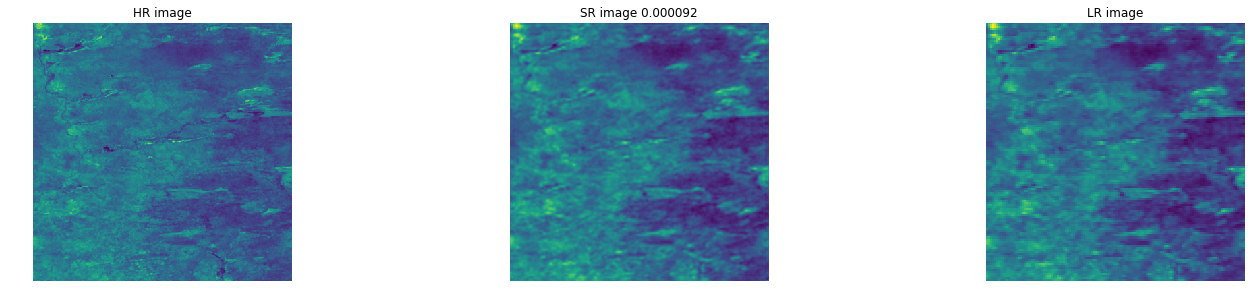

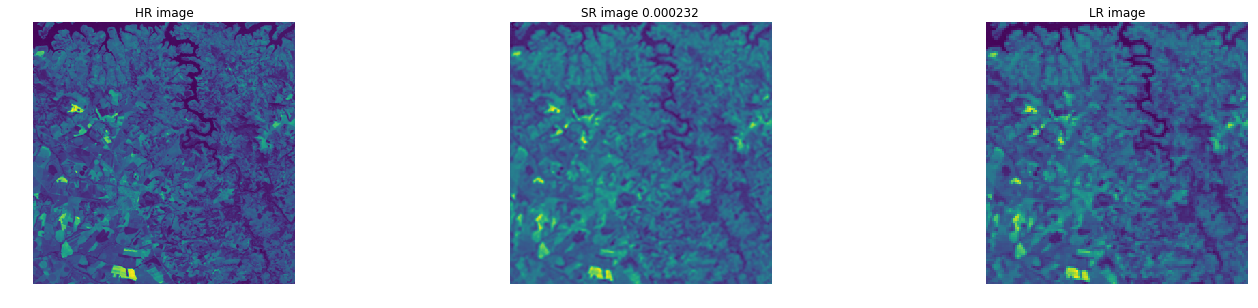

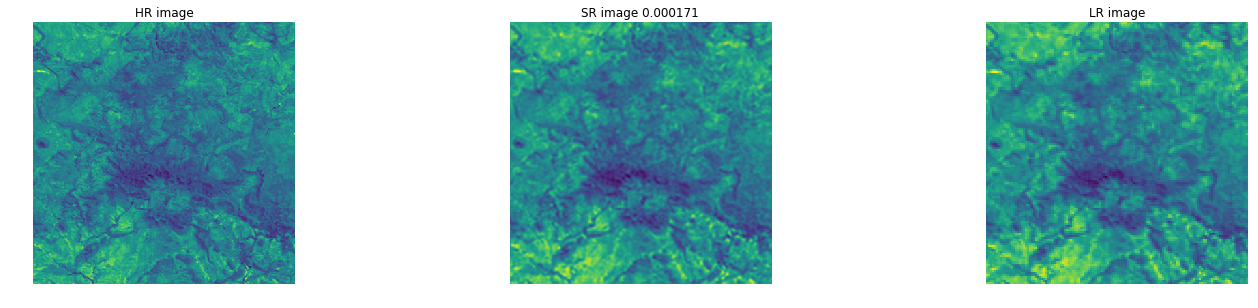

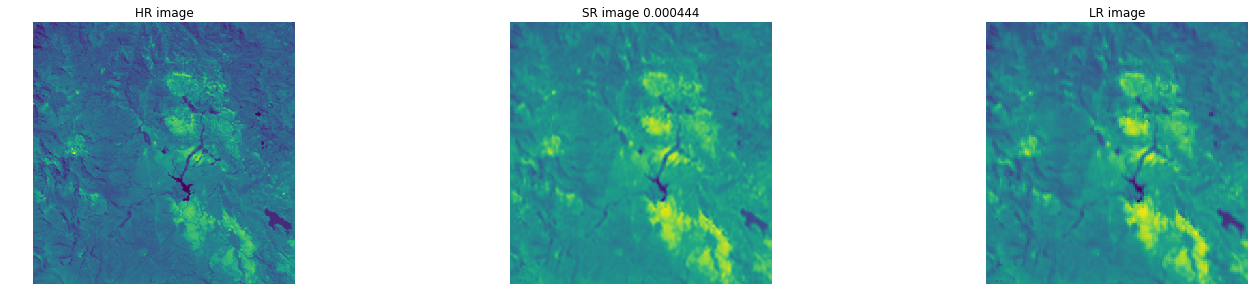

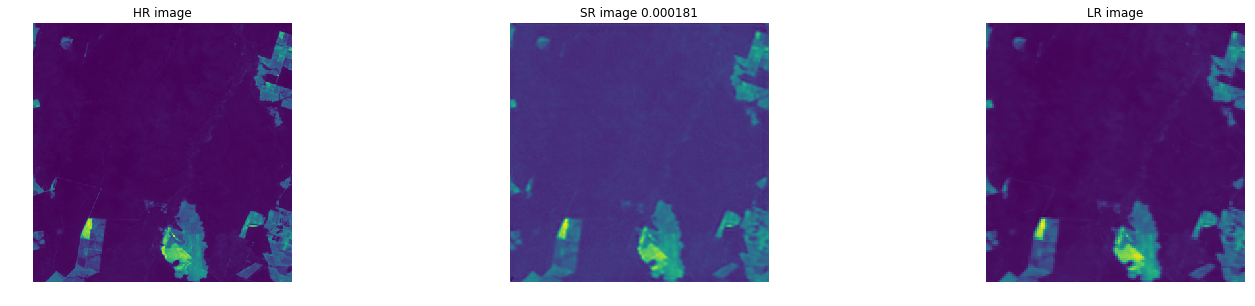

In [44]:
for i in range(5):
    example = train_folds[i]
    lr_image = agg_image(example, "mean", extend=True)
    lr_image = lr_image[np.newaxis, ...]
    sr_image = model.predict(lr_image)
    hr_image, _ = get_hr(example)
    fig = plt.figure(figsize=(20, 20))
    
    ax = fig.add_subplot(5, 3, i*3+1);
    ax.imshow(hr_image); 
    ax.set_title('HR image');
    plt.axis('off')
    
    ax = fig.add_subplot(5, 3, i*3+2); ax.imshow(sr_image[0, :,:,0]);
    ax.set_title('SR image {:.6f}'.format(np.mean(np.square(hr_image - sr_image))));
    plt.axis('off')
    
    ax = fig.add_subplot(5, 3, i*3+3); 
    ax.imshow(lr_image[0, :,:,0]); 
    ax.set_title('LR image');plt.axis('off')
    plt.tight_layout()

In [51]:
sr_paths = [predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

1.218236799623835

As we can see the result are bad, next we will use a slightly different model structure and we will upscale the picture before input it to the neural network and we will use a different loss function which is the PSNR<br>
In the previous model, we aggregate all LR image to predict the HR image.
This didn't give us good result, so we will try the following approaches:
  - combine the top clearest LR images
  - use the statue map of each image
  - use the cPSNR as loss instead of MSE


### combine k best images

Now we will select the k best images of each scene based on the quality map, and we will multiply each LR image with its corresponding status map and combine them as input to the FSRCNN network

In [70]:
def npPSNR(y_true, y_pred):
    """function to calculate the peak signal to noise rate
    we will used as the loss """
    b = np.mean(y_true - y_pred, axis=(1, 2, 3))
    cMSE = np.mean((y_true - y_pred - b)**2, axis = (1, 2, 3))
    cPSNR = -10*np.log10(cMSE)
    return 46.37/cPSNR

In [71]:
class DataLoader(Sequence):
    def __init__(self, list_paths, lr_dim=(128, 128), hr_dim=(384, 384),
                 n_channels=1, shuffle=True, batch_size=16, concat_size = 9):
        self.lr_dim = lr_dim
        self.hr_dim = hr_dim
        self.batch_size = batch_size
        self.list_paths = list_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.concat_size = concat_size
        self.on_epoch_end()

    def __len__(self):
        return 5*int(np.floor(len(self.list_paths) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def _data_generation(self, list_paths_temp):
        X = np.zeros((self.batch_size, *self.lr_dim, self.concat_size))
        y = np.zeros((self.batch_size, *self.hr_dim, self.n_channels))
        
        for i, fold in enumerate(list_paths_temp):
            lr = [l for l, q in get_lr(fold, extend=True)]
            qm = [q for l, q in get_lr(fold, extend=True)]
            hr, _ = get_hr(fold, extend=True)
            sum_qm = [np.sum(q) for q in qm]
            idx = np.argsort(sum_qm)[-self.concat_size:]
            lr = [lr[i]*qm[i] for i in idx]
            hr = [hr for i in range(self.n_channels)]
            X[i,] = np.concatenate(lr, axis=-1)
            y[i,] = np.concatenate(hr, axis=-1)
        
        return X, y
        
    def __getitem__(self, idx):
        
        indexes = self.indexes[idx*self.batch_size: (idx+1)*self.batch_size]
        
        list_paths_temp = [self.list_paths[k] for k in indexes]
        
        X, y = self._data_generation(list_paths_temp)
        return X, y

In [72]:
concat_generator_params = {'lr_dim': (128,128),
                            'hr_dim': (384,384),
                            'batch_size': 16,
                            'n_channels': 1,
                            'concat_size':9,
                            'shuffle': True}
concat_predict_dir = './predictions/fsrcnn_concat/train/'
concat_checkpoint_path = './saved_models/fsrcnn_concat.ckpt'
concat_model_path = './saved_models/fsrcnn_concat.h5'
concat_model_params = dict(d=56, s=12, m=4, channels=9, lr_dim = 128, scale = 3)

train_data = DataLoader(list_paths = X_train, **concat_generator_params)
val_data = DataLoader(list_paths = X_val, **concat_generator_params)

In [73]:
for folder in [concat_predict_dir, concat_checkpoint_path, concat_model_path]:
    folder = os.path.dirname(folder)
    os.makedirs(folder, exist_ok=True)

In [78]:
train(train_data, val_data, fsrcnn, concat_checkpoint_path, concat_model_path, epochs=300, loss=PSNR,**concat_model_params)

Epoch 1/300
290/290 [==============================] - 246s 848ms/step - loss: 0.6671 - mean_squared_error: 0.0011 - val_loss: 0.6063 - val_mean_squared_error: 1.5631e-04
Epoch 2/300
290/290 [==============================] - 242s 834ms/step - loss: 0.5847 - mean_squared_error: 3.4630e-04 - val_loss: 0.6091 - val_mean_squared_error: 3.6704e-04
Epoch 3/300
290/290 [==============================] - 244s 840ms/step - loss: 0.6225 - mean_squared_error: 0.0016 - val_loss: 0.6221 - val_mean_squared_error: 0.0010
Epoch 4/300
290/290 [==============================] - 244s 842ms/step - loss: 0.5994 - mean_squared_error: 0.0030 - val_loss: 0.6443 - val_mean_squared_error: 0.0073
Epoch 5/300
290/290 [==============================] - 244s 842ms/step - loss: 0.5885 - mean_squared_error: 0.0086 - val_loss: 0.5808 - val_mean_squared_error: 0.0112
Epoch 6/300
 60/290 [=====>........................] - ETA: 2:57 - loss: 0.5490 - mean_squared_error: 0.0117

KeyboardInterrupt: 

In [79]:
params = {'lr_dim': (128,128),
            'hr_dim': (384,384),
            'batch_size': len(train_folds),
            'n_channels': 1,
            'concat_size':9,
            'shuffle': True}
all_data = DataLoader(list_paths = train_folds, **params)

In [82]:
predict(all_data, fsrcnn, concat_checkpoint_path, loss=PSNR,**concat_model_params)

In [83]:
sr_paths = [concat_predict_dir + '/'.join(path.split('/')[-2:]) + '/SR.png' for path in train_folds]
hr_paths = [path + '/HR.png' for path in train_folds]
cPSNR_images(hr_paths, sr_paths)

1.2207732108700182

In [770]:
model = models.load_model(concat_model_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1909 (Conv2D)         (None, 128, 128, 56)      12656     
_________________________________________________________________
p_re_lu_269 (PReLU)          (None, 128, 128, 56)      917504    
_________________________________________________________________
conv2d_1910 (Conv2D)         (None, 128, 128, 12)      684       
_________________________________________________________________
p_re_lu_270 (PReLU)          (None, 128, 128, 12)      196608    
_________________________________________________________________
conv2d_1911 (Conv2D)         (None, 128, 128, 12)      1308      
_________________________________________________________________
conv2d_1912 (Conv2D)         (None, 128, 128, 12)      1308      
_________________________________________________________________
conv2d_1913 (Conv2D)         (None, 128, 128, 12)      1308      
__________

/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


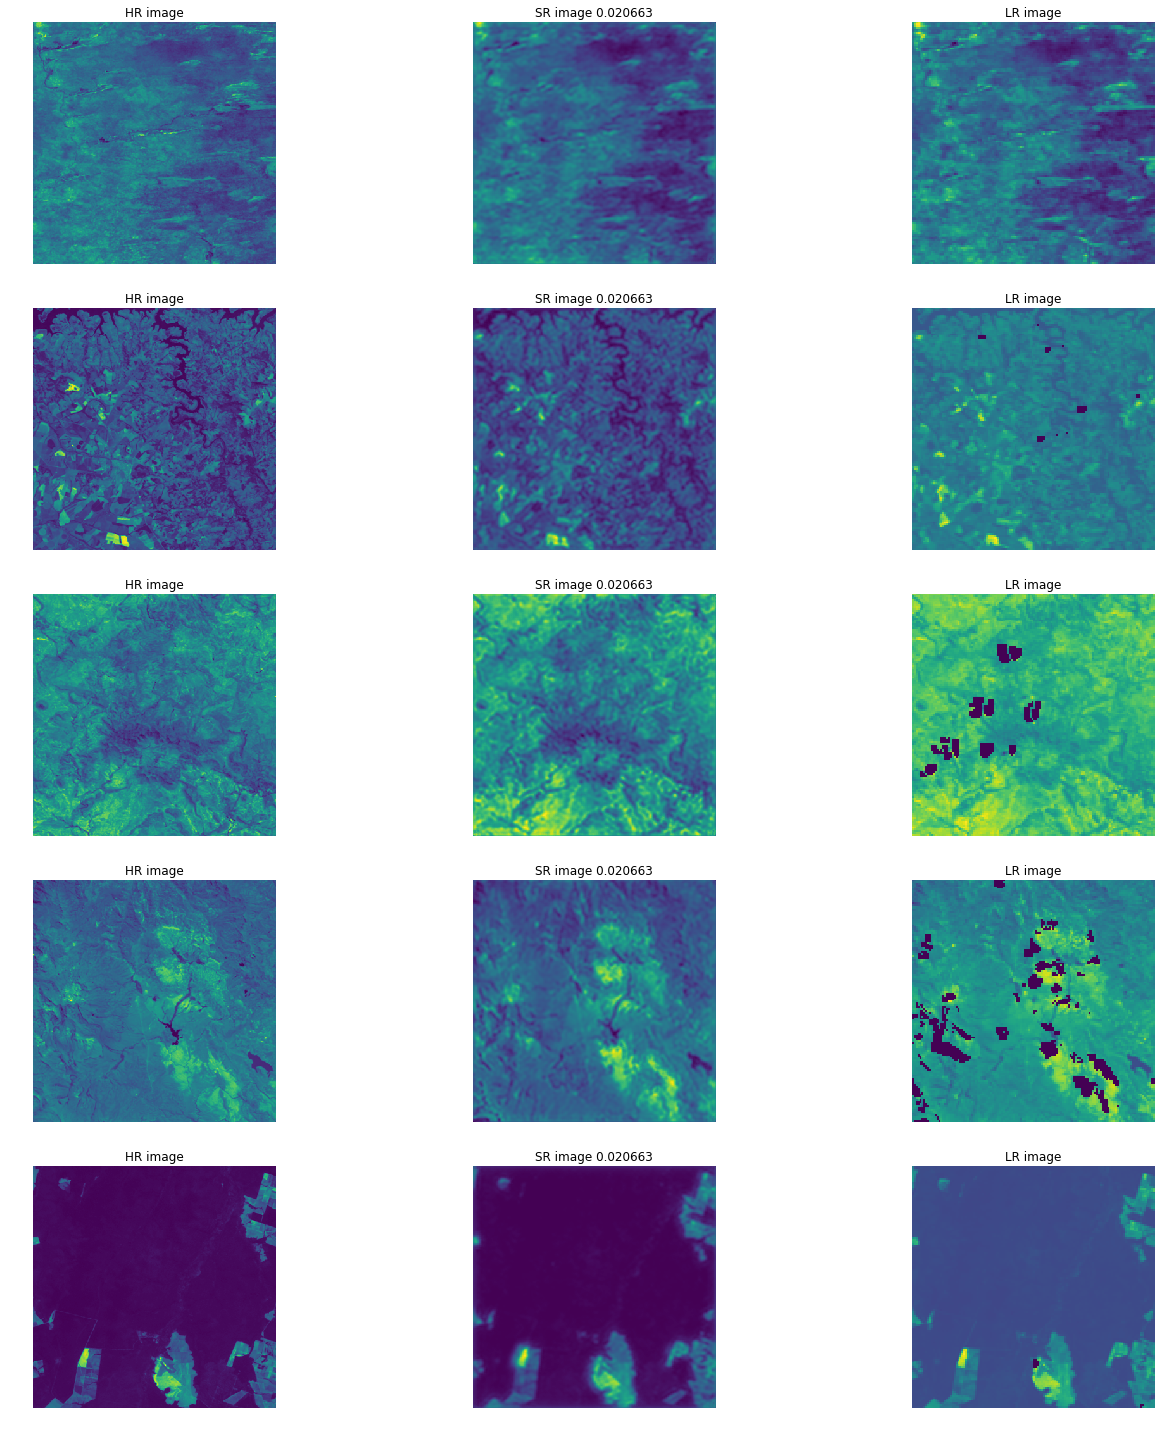

In [787]:
batch_data = DataLoader(list_paths = train_folds, shuffle=False, batch_size=5)
lr_img, hr_img = batch_data[0]
sr_image = model.predict(lr_img)
fig = plt.figure(figsize=(20, 20))
for i in range(5):
    ax = fig.add_subplot(5, 3, i*3+1); ax.imshow(hr_img[i,:,:,0]); ax.set_title('HR image'); plt.axis('off')
    ax = fig.add_subplot(5, 3, i*3+2); ax.imshow(sr_image[i, :,:,0]); ax.set_title('SR image {:.6f}'.format(np.mean(np.square(hr_image - sr_image))));
    plt.axis('off')
    ax = fig.add_subplot(5, 3, i*3+3); ax.imshow(lr_img[i,:,:,0]); ax.set_title('LR image'); plt.axis('off')
fig.tight_layout()
fig.show()
    #ax = fig.add_subplot(5, 3, i*3+3); 
    #ax.imshow(lr_img[i, :,:,0]); 
    #ax.set_title('LR image');plt.axis('off')
    

## SRGAN

Next we will use a modified version of the Super Resolution Generative Adversarial Network by Xintao and al. It is a GAN that is capable of generating realistic textures for super resolution. ESRGAN is used for single image resolution, we will apply is to our problem which is a multi-image super resolution by applying two approaches:
    - first combine top clearer pictures 
    - second use RNN layers

In [113]:
class ESRGAN():
    def __init__(self, lr_shape, hr_shape, scale, nf):
        self.lr_shape = lr_shape
        self.hr_shape = hr_shape
        self.scale = scale
        self.nf = nf
        
    def RDB(self, x):
        """Function that implement the residual dense 
        block which is the basic block of ESRGAN"""
        x1 = LeakyReLU(0.2)(Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(x))
        x2 = LeakyReLU(0.2)(Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(add([x, x1])))
        #x3 = LeakyReLU(0.2)(Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(add([x, x1, x2])))
        #x4 = LeakyReLU(0.2)(Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(add([x, x1, x2, x3])))
        x5 = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(add([x, x1, x2]))
        x5 = layers.Lambda(lambda x: x*0.2)(x5)
        return add([x5, x])
    
    def RB(self, x):
        """Function that implement the residual  
        block which is the basic block of SRGAN"""
        x1 = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(x)
        x1 = BatchNormalization(momentum=0.5)(x1)
        x1 = LeakyReLU(0.2)(x1)
        
        x1 = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(x1)
        x1 = BatchNormalization(momentum=0.5)(x1)
        
        return add([x1, x])
    
    def upsampling(self, x, scale):
        x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
        x = UpSampling2D(scale)(x)
        x = LeakyReLU(0.2)(x)
        return x
    
    def RRDB(self, x):
        """Function that implement the residual in residual dense 
        block which is conposed of three RDB"""
        y = self.RDB(x)
        y = self.RDB(y)
        y = self.RDB(y)
        y = layers.Lambda(lambda x: x*0.2)(y)
        return add([y, x])
        
    def Generator(self):
        inputs = Input(shape=(self.lr_shape[0], self.lr_shape[1], 3))
        x = Conv2D(filters=self.nf, kernel_size=9, strides=1, padding='same')(inputs)
        x = LeakyReLU(0.2)(x)
        x1 = x
        # this one used in case of ESRGAN
        x = self.RRDB(x)
        # this one used in case of SRGAN
        # for _ in range(4):  
        #    x = self.RB(x)  # 
        x = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(x)
        x = concatenate([x, x1])
        x = self.upsampling(x, self.scale)
        x = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')(x)
        gen = Model(inputs = inputs, outputs = x)
        return gen
    
    def Discriminator(self):
        
        def basic_block(x, k, n, s):
            x = Conv2D(kernel_size=k, filters=n, strides=s, padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(0.2)(x)
            return x
        
        inputs = Input(shape=(self.hr_shape[0], self.hr_shape[1], 3))
        x = Conv2D(self.nf, kernel_size=3, strides=1, padding='same')(inputs)
        x = LeakyReLU(0.2)(x)
        
        x = basic_block(x, 3, self.nf, 2)
        x = basic_block(x, 3, self.nf*2, 1)
        x = basic_block(x, 3, self.nf*2, 2)
        x = basic_block(x, 3, self.nf*4, 1)
        x = basic_block(x, 3, self.nf*4, 2)
        x = basic_block(x, 3, self.nf*8, 1)
        x = basic_block(x, 3, self.nf*8, 2)
        
        x = Flatten()(x)
        x = Dense(1024)(x)
        x = LeakyReLU(0.2)(x)
        x = Dense(1, activation='sigmoid')(x)
        
        des = Model(inputs= inputs, outputs = x)
        
        return des


def process_vgg(x):
    # transform image from [0,1] to [0, 255]
    x *= 255
    x = x[..., ::-1]
    # imagenet mean
    mean = [103.939, 116.778, 123.68]
    imagenet_mean = K.constant(-np.array(mean))
    x = K.bias_add(x, K.cast(imagenet_mean, K.dtype(x)))
    
    return x

def vgg_loss(y_true, y_pred):
    """content loss"""
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(HR_IMG_SIZE, HR_IMG_SIZE, 3))
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
    model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block2_conv2').output)
    model.trainable = False
    return 0.006*K.mean(K.square(model(process_vgg(y_true)) - model(process_vgg(y_pred))))
    
def create_gan(discriminator, generator, shape, vgg_loss):
    discriminator.trainable = False
    input_generator_gan = Input(shape=shape)
    output_generator_gan = generator(input_generator_gan)
    output_discriminator_gan = discriminator(output_generator_gan)
    gan = Model(inputs=input_generator_gan, outputs=[output_generator_gan,output_discriminator_gan])
    gan.compile(loss=[vgg_loss, "binary_crossentropy"],
                loss_weights=[1., 1e-3],
                optimizer=Adam(lr=1e-4, beta_1=0.9))
    return gan

In [105]:
def train_gan(train_data, val_data, epochs, model_path, scale=3, nf=64):
    esrgan = ESRGAN(train_data.lr_dim, train_data.hr_dim, scale, nf)
    
    generator = esrgan.Generator()
    discriminator = esrgan.Discriminator()
    
    generator.compile(optimizer = Adam(lr=1e-4, beta_1=0.9), loss = vgg_loss)
    discriminator.compile(optimizer = Adam(lr=1e-4, beta_1=0.9), loss = "binary_crossentropy")
    
    gan = create_gan(discriminator, generator, esrgan.lr_shape+(3,), vgg_loss)
    
    list_d_loss_fake = []
    list_d_loss_real = []
    list_g_loss_vgg = []
    list_g_loss_crentropy = []
    
    for epoch in range(1, epochs+1):
        epoch_start = time.time()
        
        print("Epoch {}/{}".format(epoch, epochs))
        
        for i in tqdm(range(len(train_data)//3)):
            
            #generate data 
            start = time.time()
            lr_image, hr_image = train_data[i*3]
            sr_image = generator.predict(lr_image)
            print("predict generator %f s" %(time.time()-start))
            
            # Train Discriminator on generated image
            start = time.time()
            discriminator.trainable = True
            fake_label = np.random.uniform(0.0, 0.3, size=(sr_image.shape[0]))
            d_loss_fake = discriminator.train_on_batch(sr_image, fake_label)
            list_d_loss_fake.append(d_loss_fake)
            print("train discriminator on fake %f s" %(time.time()-start))
            
            # Train Discriminator on real image
            start = time.time()
            lr_image, hr_image = train_data[i*3+1]
            real_label = np.random.uniform(0.7, 1.2, size=(hr_image.shape[0]))
            d_loss_real = discriminator.train_on_batch(hr_image, real_label)
            list_d_loss_real.append(d_loss_real)
            print("train discriminator or real %f s" %(time.time()-start))
            
            # Train Generator
            start = time.time()
            discriminator.trainable = False
            lr_image, hr_image = train_data[i*3+2]
            gan_label = np.ones((lr_image.shape[0],1))
            gan_loss = gan.train_on_batch(lr_image, [hr_image, gan_label])
            list_g_loss_vgg.append(gan_loss[0])
            list_g_loss_crentropy.append(gan_loss[1])
            print("train generator %f s" %(time.time()-start))
            
        
        print("discriminator fake loss : {} - discriminator real loss : {}".format(np.mean(list_d_loss_fake[-len(train_data):]),
                                                                                   np.mean(list_d_loss_real[-len(train_data):])))
        print("gan vgg loss : {} - gan cross_entropy loss : {}".format(np.mean(list_g_loss_vgg[-len(train_data):]),
                                                                       np.mean(list_g_loss_crentropy[-len(train_data):])))
        print("Epoch {} finished in {}".format(epoch, time.time()-epoch_start))
        evaluate_generator(generator, val_data)
        if epoch % 1 == 0:
            generator.save(model_path + 'gen_model{}.h5'.format(epoch))
            #discriminator.save(model_path + 'dis_model{}.h5'.format(epoch))

In [114]:
def evaluate_generator(generator, data):
    lr_image, hr_image = data[0]
    sr_image = generator.predict(lr_image)
    mse = np.mean((sr_image- hr_image)**2)
    print("val_mse: {} - val_PSNR: {}".format(mse, npPSNR(hr_image, sr_image)))

In [115]:
gan_generator_params = {'lr_dim': (128,128),
                            'hr_dim': (384,384),
                            'n_channels': 3,
                            'concat_size':3,
                            'shuffle': True}
gan_predict_dir = './predictions/gan/train/'
gan_checkpoint_path = './saved_models/gan/'
gan_model_params = dict(lr_shape=(128,128), hr_shape = (384,384), scale = 3, nf= 64, nbb = 4)
train_data = DataLoader(list_paths = X_train, batch_size= 32, **gan_generator_params)
val_data = DataLoader(list_paths = X_val, batch_size= len(X_val), **gan_generator_params)

In [116]:
train_gan(train_data, val_data, epochs=50, model_path=gan_checkpoint_path)

Epoch 1/50


predict generator 9.937998 s
train discriminator on fake 31.782779 s
train discriminator or real 22.288685 s
train generator 65.989976 s
predict generator 6.871308 s
train discriminator on fake 14.638159 s
train discriminator or real 16.986119 s
train generator 56.694805 s
predict generator 7.330318 s
train discriminator on fake 15.293361 s
train discriminator or real 17.337796 s
train generator 53.267576 s
predict generator 7.141621 s
train discriminator on fake 15.132408 s
train discriminator or real 17.799301 s
train generator 63.383876 s
predict generator 8.239008 s
train discriminator on fake 14.513556 s
train discriminator or real 17.526571 s
train generator 56.242656 s
predict generator 7.414108 s
train discriminator on fake 14.882821 s
train discriminator or real 17.026834 s
train generator 54.781636 s
predict generator 7.457296 s
train discriminator on fake 15.702818 s
train discriminator or real 18.076937 s
train generator 72.714144 s
predict generator 7.046295 s
train discri

predict generator 6.648989 s
train discriminator on fake 18.396937 s
train discriminator or real 18.352646 s
train generator 54.915741 s
predict generator 6.321331 s
train discriminator on fake 15.734763 s
train discriminator or real 17.763579 s
train generator 55.165857 s
predict generator 6.316012 s
train discriminator on fake 17.483762 s
train discriminator or real 20.472824 s
train generator 55.007332 s
predict generator 6.386848 s
train discriminator on fake 16.420945 s
train discriminator or real 17.980131 s
train generator 54.359107 s
predict generator 6.370889 s
train discriminator on fake 17.950898 s
train discriminator or real 18.152200 s
train generator 56.117550 s
predict generator 6.378096 s
train discriminator on fake 17.773962 s
train discriminator or real 17.560252 s
train generator 57.274491 s
predict generator 6.267437 s
train discriminator on fake 15.923630 s
train discriminator or real 18.261178 s
train generator 57.529600 s
predict generator 6.174476 s
train discri

predict generator 6.414002 s
train discriminator on fake 16.346117 s
train discriminator or real 18.638234 s
train generator 57.784480 s
predict generator 6.323100 s
train discriminator on fake 17.704294 s
train discriminator or real 17.692181 s
train generator 58.204051 s
predict generator 6.308276 s
train discriminator on fake 16.230553 s
train discriminator or real 18.781891 s
train generator 57.829329 s
predict generator 6.501758 s
train discriminator on fake 17.957479 s
train discriminator or real 18.179235 s
train generator 56.293731 s
predict generator 6.309423 s
train discriminator on fake 19.224487 s
train discriminator or real 18.905063 s
train generator 58.189402 s
predict generator 6.211220 s
train discriminator on fake 17.957703 s
train discriminator or real 17.928452 s
train generator 56.216745 s
predict generator 6.405155 s
train discriminator on fake 16.165027 s
train discriminator or real 18.484929 s
train generator 56.555975 s
predict generator 6.453652 s
train discri

predict generator 6.117969 s
train discriminator on fake 17.753073 s
train discriminator or real 18.260336 s
train generator 57.657553 s
predict generator 6.359310 s
train discriminator on fake 18.427371 s
train discriminator or real 17.939798 s
train generator 58.329475 s
predict generator 6.228557 s
train discriminator on fake 16.170738 s
train discriminator or real 18.184402 s
train generator 55.156750 s
predict generator 6.262675 s
train discriminator on fake 17.483828 s
train discriminator or real 17.878818 s
train generator 57.313962 s
predict generator 6.443479 s
train discriminator on fake 18.558225 s
train discriminator or real 19.026548 s
train generator 57.034381 s
predict generator 6.287142 s
train discriminator on fake 17.503977 s
train discriminator or real 18.555695 s
train generator 57.832291 s
predict generator 6.337727 s
train discriminator on fake 17.968325 s
train discriminator or real 18.212105 s
train generator 55.629805 s
predict generator 6.499560 s
train discri

predict generator 6.070887 s
train discriminator on fake 18.254892 s
train discriminator or real 17.982994 s
train generator 55.436407 s
predict generator 6.331501 s
train discriminator on fake 16.926708 s
train discriminator or real 19.217753 s
train generator 53.452226 s
predict generator 6.442702 s
train discriminator on fake 16.171287 s
train discriminator or real 18.045560 s
train generator 56.355979 s
predict generator 6.342947 s
train discriminator on fake 16.593400 s
train discriminator or real 18.014278 s
train generator 56.968526 s
predict generator 6.343587 s
train discriminator on fake 16.876705 s
train discriminator or real 18.375271 s
train generator 55.833730 s
predict generator 6.357094 s
train discriminator on fake 15.991184 s
train discriminator or real 18.166572 s
train generator 57.627019 s
predict generator 6.790453 s
train discriminator on fake 15.865695 s
train discriminator or real 18.851352 s
train generator 53.681850 s
predict generator 6.357015 s
train discri

predict generator 6.138860 s
train discriminator on fake 17.327362 s
train discriminator or real 18.220083 s
train generator 55.248709 s
predict generator 6.198099 s
train discriminator on fake 17.952480 s
train discriminator or real 18.415925 s
train generator 54.801672 s
predict generator 6.414301 s
train discriminator on fake 16.377393 s
train discriminator or real 17.210648 s
train generator 53.367584 s
predict generator 6.159678 s
train discriminator on fake 17.105264 s
train discriminator or real 18.244826 s
train generator 52.992061 s
predict generator 6.067371 s
train discriminator on fake 18.553476 s


KeyboardInterrupt: 

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Input, Lambda
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.backend import tf as tfk


f = 32
D = 5
R = 3

def feature_embedding(filters=f, conv_num=D): 
    inputs = Input(shape=(None, None, filters))
    
    x = LeakyReLU(0.2)(inputs)
    x = Conv2D(filters, kernel_size=3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    for _ in range(conv_num-1):
        x = LeakyReLU(0.2)(x)
        x = Conv2D(filters, kernel_size=3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

def _upsample_and_condense(x, filters=f):

    x = LeakyReLU(0.2)(x)
    upsample = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(upsample)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    condense = Conv2D(1, kernel_size=3, padding='same', use_bias=False)(x)
    return condense, upsample

def residual_block(recursive_num=R, filters=f):

    embedding = feature_embedding()
    inputs = Input(shape=(None, None, filters))
    x = embedding(inputs)
    x = Add()([x, inputs])
    for _ in range(recursive_num-1):
        x = embedding(x)
        x = Add()([x, inputs])
    res, upsample = _upsample_and_condense(x)
    model = Model(inputs=inputs, outputs=[res, upsample])
    return model

def upsample_block(filters=f):

    img_input = Input(shape=(None, None, 1))
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(img_input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    upsample = Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    model = Model(inputs=img_input, outputs=upsample, name="upsample")
    return model

def conv_block(filters=f):
    """"""
    img_input = Input(shape=(None, None, 1))
    
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(img_input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    output = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    
    model = Model(inputs=img_input, outputs=output, name="init_embedd")
    return model

def lapsrn(lr_dim, hr_dim):
    
    conv = conv_block()
    residual = residual_block()
    upsample = upsample_block()

    inputs = Input(shape=(lr_dim, lr_dim, 1))
    
    # X2
    conv_1 = conv(inputs)
    upsample_1 = upsample(inputs)
    residual_1, f_upsample_1 = residual(conv_1)
    hr1 = Add()([upsample_1, residual_1])
    
    #X4
    upsample_2 = upsample(hr1)
    residual_2, f_upsample_2 = residual(f_upsample_1)
    hr2 = Add()([upsample_2, residual_2])
    
    #X3
    hr2 = Lambda(lambda img: tfk.image.resize_images(img, (hr_dim, hr_dim)))(hr2)
    model = Model(inputs=inputs, outputs=hr2)

    return models

In [ ]:
model = lapsrn(128, 384)
model.summary()